Churn prediction using logistic regression
Churn means “leaving the company”. We try to predict if the customer will churn or not given his details.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data=pd.read_csv('churn_prediction.csv')

In [3]:
data.head()

,customer_id,vintage,age,gender,dependents,occupation,city,customer_nw_category,branch_code,days_since_last_transaction,...,previous_month_end_balance,average_monthly_balance_prevQ,average_monthly_balance_prevQ2,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn
0,1,3135,66,Male,0.0,self_employed,187.0,2,755,224.0,...,1458.71,1458.71,1449.07,0.20,0.20,0.20,0.20,1458.71,1458.71,0
1,2,310,35,Male,0.0,self_employed,NaN,2,3214,60.0,...,8704.66,7799.26,12419.41,0.56,0.56,5486.27,100.56,6496.78,8787.61,0
2,4,2356,31,Male,0.0,salaried,146.0,2,41,NaN,...,5815.29,4910.17,2815.94,0.61,0.61,6046.73,259.23,5006.28,5070.14,0
3,5,478,90,NaN,NaN,self_employed,1020.0,2,582,147.0,...,2291.91,2084.54,1006.54,0.47,0.47,0.47,2143.33,2291.91,1669.79,1
4,6,2531,42,Male,2.0,self_employed,1494.0,3,388,58.0,...,1401.72,1643.31,1871.12,0.33,714.61,588.62,1538.06,1157.15,1677.16,1


**customer_id	vintage	age	gender	dependents	occupation	city** are demographic info about customers


**customer_nw_category	branch_code	days_since_last_transaction** are infomation about customer bank relationship


**customer_balance previous_month_end_balance	average_monthly_balance_prevQ	average_monthly_balance_prevQ2	current_month_credit	previous_month_credit	current_month_debit	previous_month_debit	current_month_balance	previous_month_balance** are transcational information availble

Importing the methods and functions

In [4]:
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold,StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix,roc_curve,precision_score,recall_score,precision_recall_curve

Checking if the data has missing values

In [5]:
data.isnull().sum()

customer_id                          0
vintage                              0
age                                  0
gender                             525
dependents                        2463
occupation                          80
city                               803
customer_nw_category                 0
branch_code                          0
days_since_last_transaction       3223
current_balance                      0
previous_month_end_balance           0
average_monthly_balance_prevQ        0
average_monthly_balance_prevQ2       0
current_month_credit                 0
previous_month_credit                0
current_month_debit                  0
previous_month_debit                 0
current_month_balance                0
previous_month_balance               0
churn                                0
dtype: int64

In [6]:
data['gender'].value_counts()

Male      16548
Female    11309
Name: gender, dtype: int64

In [7]:
#Encoding the gender column
dict_gender={'Male':1,'Female':0}
data.replace({'gender':dict_gender},inplace=True)

In [8]:
data['dependents'].value_counts()

0.0     21435
2.0      2150
1.0      1395
3.0       701
4.0       179
5.0        41
6.0         8
7.0         3
9.0         1
52.0        1
36.0        1
50.0        1
8.0         1
25.0        1
32.0        1
Name: dependents, dtype: int64

In [9]:
data['occupation'].value_counts()

self_employed    17476
salaried          6704
student           2058
retired           2024
company             40
Name: occupation, dtype: int64

Making the mode of dependents and occupation as data values for the missing columns

In [10]:
data['depedents']=data['dependents'].fillna(0)
data['occupation']=data['occupation'].fillna('self_empolyed')

In [11]:
data['city']=data['city'].fillna(data['city'].mode())#mode of city

In [12]:
data['days_since_last_transaction']=data['days_since_last_transaction'].fillna(999)

In [13]:
data.isnull().sum()

customer_id                          0
vintage                              0
age                                  0
gender                             525
dependents                        2463
occupation                           0
city                               803
customer_nw_category                 0
branch_code                          0
days_since_last_transaction          0
current_balance                      0
previous_month_end_balance           0
average_monthly_balance_prevQ        0
average_monthly_balance_prevQ2       0
current_month_credit                 0
previous_month_credit                0
current_month_debit                  0
previous_month_debit                 0
current_month_balance                0
previous_month_balance               0
churn                                0
depedents                            0
dtype: int64

In [14]:
data=pd.concat([data,pd.get_dummies(data['occupation'],prefix=str('occupation'),prefix_sep='_')],axis=1)

In [15]:
col=['customer_nw_category','current_balance','previous_month_end_balance','average_monthly_balance_prevQ2', 'average_monthly_balance_prevQ',
            'current_month_credit','previous_month_credit', 'current_month_debit', 
            'previous_month_debit','current_month_balance', 'previous_month_balance']
for i in col:
    data[i]=np.log(data[i]+17000)
std=StandardScaler()
scaled=std.fit_transform(data[col])
scaled=pd.DataFrame(scaled,columns=col)

In [16]:
data_data_og=data.copy()

In [17]:
data=data.drop(columns=col,axis=1)

In [18]:
data=data.merge(scaled,left_index=True,right_index=True,how='left')

In [19]:
y_all=data.churn

In [20]:
data=data.drop(['churn','customer_id','occupation'],axis=1)

In [21]:
baseline_col=['current_month_debit', 'previous_month_debit','current_balance','previous_month_end_balance','vintage'
                 ,'occupation_retired', 'occupation_salaried','occupation_self_employed', 'occupation_student']

In [22]:
data_baseline=data[baseline_col]

In [23]:
x_train,x_test,y_train,y_test=train_test_split(data_baseline,y_all,test_size=0.33,random_state=11,stratify=y_all)

In [24]:
model=LogisticRegression()

In [25]:
model.fit(x_train,y_train)

LogisticRegression()

In [26]:
pred=model.predict_proba(x_test)[:,1]

In [27]:
from sklearn.metrics import roc_curve

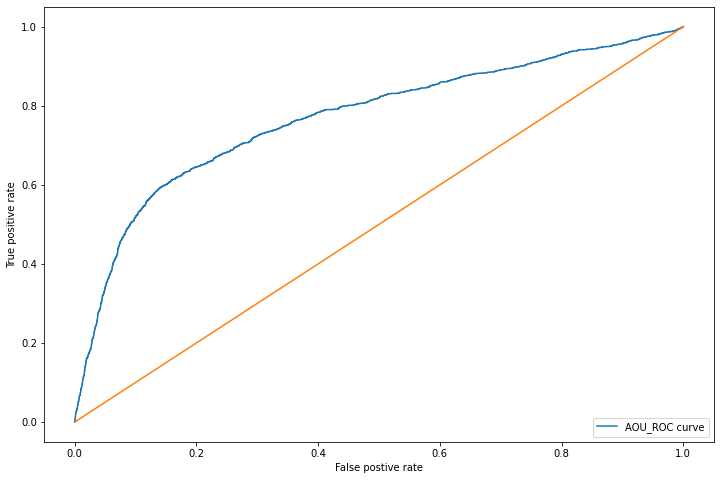

In [28]:
fpr,tpr,_=roc_curve(y_test,pred)
auc=roc_auc_score(y_test,pred)
plt.figure(figsize=(12,8))
plt.plot(fpr,tpr,label='AOU_ROC curve')
x=np.linspace(0,1,100)
plt.plot(x,x,linestyle='-')
plt.xlabel('False postive rate')
plt.ylabel('True positive rate')
plt.legend(loc=4)
plt.show()

In [29]:
pred_value=model.predict(x_test)

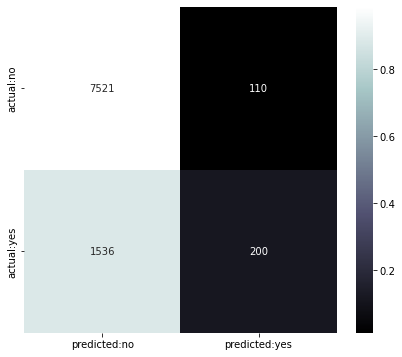

In [30]:
label_pred=pred_value
cm=confusion_matrix(y_test,label_pred)
def plot_confusion_matrix(cm,normalized=True,cmap='bone'):
    plt.figure(figsize=[7,6])
    norm_cm=cm
    if normalized:
        norm_cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        sns.heatmap(norm_cm,annot=cm,fmt='g',xticklabels=['predicted:no', 'predicted:yes'],yticklabels=['actual:no','actual:yes'],cmap=cmap)
plot_confusion_matrix(cm,['no','yes'])

In [31]:
recall_score(y_test,pred_value)

0.1152073732718894

In [33]:
y_all.value_counts()

0    23122
1     5260
Name: churn, dtype: int64